🔄 [1단계] 44개 원본 데이터 파일 통합 중...
✅ 원본 데이터 로드 완료 (69522행)
🔄 경기도 대조군 데이터 생성 중...

🚀 분석 시작: 500m (역별_행궁동_상권 정리표.xlsx)


C:\Users\USER\AppData\Local\Temp\ipykernel_19032\2907814531.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  if '노선' in df_meta.columns: df_meta['노선'] = df_meta['노선'].fillna(method='ffill')


📈 [500m] 그래프 생성 중...


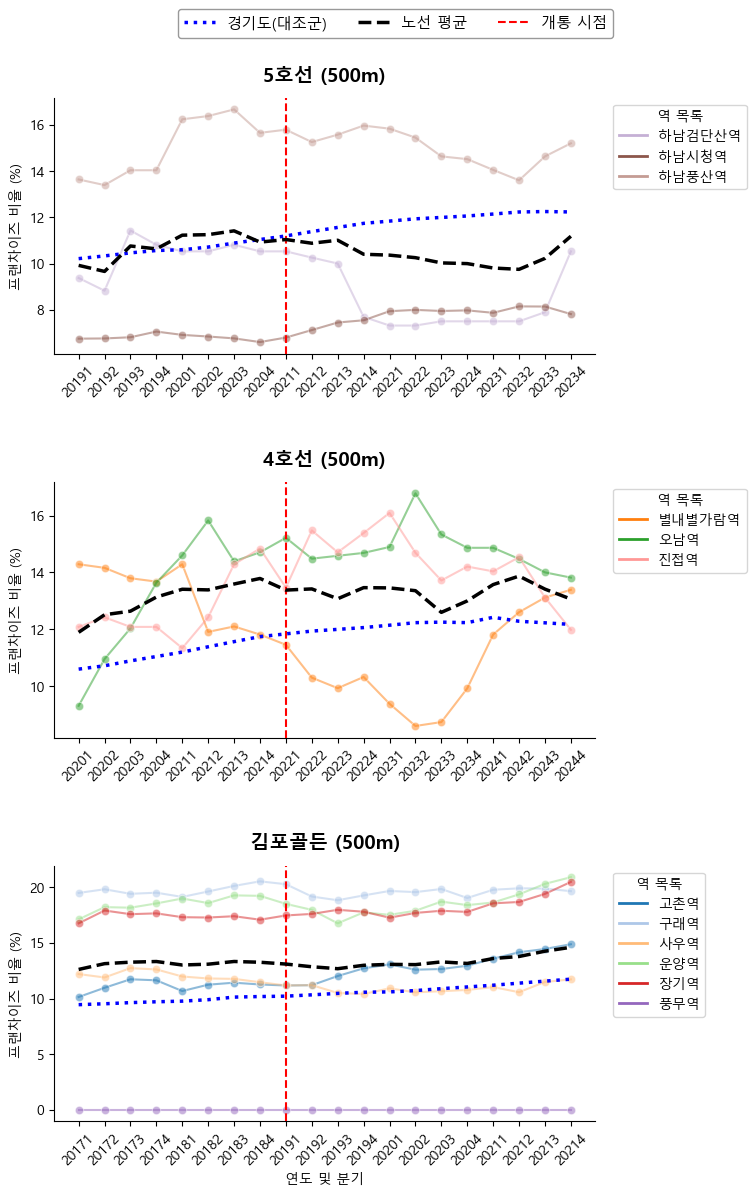


🚀 분석 시작: 500m~2km (역별_행궁동_상권 정리표(5~20).xlsx)
📈 ~2km] 그래프 생성 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_19032\2907814531.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  if '노선' in df_meta.columns: df_meta['노선'] = df_meta['노선'].fillna(method='ffill')


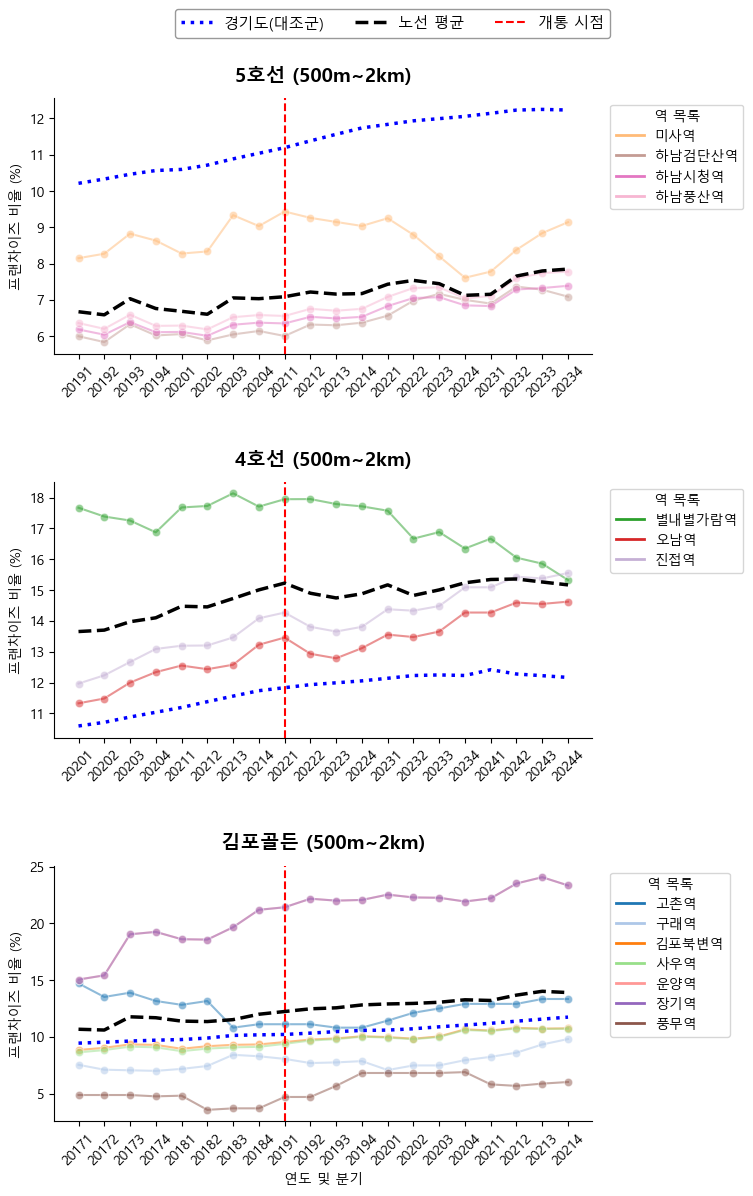

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import pandas as pd
import os
import glob
import re
import platform

# 1. 시각화 환경 설정
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

try:
    # =========================================================================
    # [STEP 1] 원본 데이터 로드 (df_all) - 공통
    # =========================================================================
    if 'df_all' not in locals():
        print("🔄 [1단계] 44개 원본 데이터 파일 통합 중...")
        raw_data_dir = r"C:/Users/USER/Desktop/새 폴더 (4)"
        commercial_districts = ['골목', '발달', '전통시장', '진흥']
        all_data = []
        ID_VARS = ['행정구역', '시군구코드', '상권_유형'] 

        for c_type in commercial_districts:
            folder_path = os.path.join(raw_data_dir, c_type)
            all_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
            file_list = [f for f in all_files if not os.path.basename(f).startswith('~$')]
            for file_path in file_list:
                try:
                    df = pd.read_excel(file_path, sheet_name=0)
                    df['상권_유형'] = c_type
                    value_vars = [col for col in df.columns if '점포수' in col]
                    df_long = pd.melt(df, id_vars=ID_VARS, value_vars=value_vars, var_name='분기_변수명', value_name='값')
                    df_long['분기_스트링'] = df_long['분기_변수명'].apply(lambda x: re.search(r'(\d{4})년(\d)분기', x))
                    df_long['분기'] = df_long['분기_스트링'].apply(lambda x: f"{x.group(1)}{x.group(2)}" if x else None)
                    df_long['점포_유형'] = df_long['분기_변수명'].apply(lambda x: re.sub(r'\d{4}년\d분기 ', '', x))
                    df_pivot = df_long.pivot_table(index=['행정구역', '시군구코드', '상권_유형', '분기'], columns='점포_유형', values='값').reset_index()
                    df_pivot = df_pivot.rename(columns={'전체점포수': '점포_수', '프랜차이즈 점포수': '프랜차이즈_점포_수', '행정구역': '상권_코드_명'})
                    all_data.append(df_pivot)
                except: pass
        
        if not all_data: raise ValueError("데이터 로드 실패")
        df_all = pd.concat(all_data, ignore_index=True)
        # 비율 1차 계산
        df_all.loc[df_all['점포_수'] > 0, '프랜차이즈_비율'] = (df_all['프랜차이즈_점포_수'] / df_all['점포_수']) * 100
        df_all['프랜차이즈_비율'] = df_all['프랜차이즈_비율'].fillna(0)
        df_all['분기_숫자'] = df_all['분기'].astype(int)
        df_all['분기_str'] = df_all['분기'].astype(str)
        print(f"✅ 원본 데이터 로드 완료 ({len(df_all)}행)")

    # -------------------------------------------------------------------------
    # [STEP 2] 경기도 대조군 준비 - 공통
    # -------------------------------------------------------------------------
    if 'df_gyeonggi_agg' not in locals():
        print("🔄 경기도 대조군 데이터 생성 중...")
        df_gyeonggi_raw = df_all[df_all['상권_코드_명'] == '경기도'].copy()
        df_gyeonggi_agg = df_gyeonggi_raw.groupby(['분기', '분기_숫자', '분기_str'])[['점포_수', '프랜차이즈_점포_수']].sum().reset_index()
        df_gyeonggi_agg['프랜차이즈_비율'] = (df_gyeonggi_agg['프랜차이즈_점포_수'] / df_gyeonggi_agg['점포_수']) * 100
        df_gyeonggi_agg['역이름'] = '경기도(대조군)' 

    # =========================================================================
    # [핵심 함수] 분석 및 시각화 통합 함수 (점포수 제거됨)
    # =========================================================================
    def run_analysis_and_plot(mapping_file_path, distance_label):
        print(f"\n🚀 분석 시작: {distance_label} ({os.path.basename(mapping_file_path)})")
        
        # 1. 매핑 파일 로드
        if mapping_file_path.endswith('.xlsx'): df_meta = pd.read_excel(mapping_file_path, sheet_name=0)
        else: df_meta = pd.read_csv(mapping_file_path, encoding='cp949')
        if '노선' in df_meta.columns: df_meta['노선'] = df_meta['노선'].fillna(method='ffill')

        map_list = []
        for col in ['골목', '발달', '전통시장', '진흥']:
            if col in df_meta.columns:
                temp = df_meta[['노선', '역이름', col]].copy()
                temp['상권_리스트'] = temp[col].astype(str).str.split(',')
                temp = temp.explode('상권_리스트')
                temp['상권_코드_명'] = temp['상권_리스트'].str.strip()
                temp = temp[~temp['상권_코드_명'].isin(['nan', '', 'nan'])]
                map_list.append(temp[['노선', '역이름', '상권_코드_명']])
        df_mapping = pd.concat(map_list).drop_duplicates()

        # 2. 데이터 병합
        df_clean = df_all.drop(columns=['노선', '역이름'], errors='ignore')
        df_merged = pd.merge(df_clean, df_mapping, on='상권_코드_명', how='inner')
        # [주의] 하남시청역 포함 (필터링 X)
        
        # 3. 역 단위 통합 (비율만 계산)
        LINE_OPENING_INFO = {
            '5호선': {'start_q': 20191, 'end_q': 20234, 'open_q': 20211},
            '4호선': {'start_q': 20201, 'end_q': 20244, 'open_q': 20221},
            '김포골든': {'start_q': 20171, 'end_q': 20214, 'open_q': 20191}
        }
        viz_list_station = [] 
        viz_list_gg = []      

        for line_name, info in LINE_OPENING_INFO.items():
            temp = df_merged[df_merged['노선'].astype(str).str.contains(line_name)].copy()
            if temp.empty: continue
            
            # 역 단위 통합 (Sum)
            temp_agg = temp.groupby(['노선', '역이름', '분기', '분기_숫자', '분기_str'])[['점포_수', '프랜차이즈_점포_수']].sum().reset_index()
            # 비율 재계산 (가중 평균 효과)
            temp_agg['프랜차이즈_비율'] = (temp_agg['프랜차이즈_점포_수'] / temp_agg['점포_수']) * 100
            temp_agg['분석_노선'] = line_name
            temp_agg = temp_agg[(temp_agg['분기_숫자'] >= info['start_q']) & (temp_agg['분기_숫자'] <= info['end_q'])]
            viz_list_station.append(temp_agg)

            # 경기도 대조군 (비율용)
            temp_gg = df_gyeonggi_agg.copy()
            temp_gg['분석_노선'] = line_name
            temp_gg = temp_gg[(temp_gg['분기_숫자'] >= info['start_q']) & (temp_gg['분기_숫자'] <= info['end_q'])]
            viz_list_gg.append(temp_gg)

        df_station_final = pd.concat(viz_list_station, ignore_index=True)
        df_gg_final = pd.concat(viz_list_gg, ignore_index=True)

        # 4. 시각화 (타이틀 커스텀)
        print(f"📈 [{distance_label}] 그래프 생성 중...")
        
        # 색상 매핑
        all_stations = sorted(df_station_final['역이름'].unique())
        palette_values = sns.color_palette("tab20", n_colors=len(all_stations))
        station_color_map = dict(zip(all_stations, palette_values))

        g = sns.relplot(
            data=df_station_final, x='분기_str', y='프랜차이즈_비율',
            hue='역이름', col='분석_노선', col_wrap=1,
            kind='line', marker='o',
            height=4, aspect=2.0, alpha=0.5, linewidth=1.5,
            palette=station_color_map,
            facet_kws={'sharex': False, 'sharey': False}, legend=False 
        )

        for ax in g.axes.flat:
            curr_line = ax.get_title().split('=')[-1].strip()
            
            # [타이틀 수정] "노선명 (거리범위)"
            new_title = f"{curr_line} ({distance_label})"
            ax.set_title(new_title, fontsize=14, fontweight='bold', pad=12)

            # 경기도 대조군
            gg_data = df_gg_final[df_gg_final['분석_노선'] == curr_line]
            if not gg_data.empty:
                sns.lineplot(data=gg_data, x='분기_str', y='프랜차이즈_비율', ax=ax, 
                             color='blue', linestyle=':', linewidth=2.5, zorder=5)

            # 노선 평균
            line_data = df_station_final[df_station_final['분석_노선'] == curr_line]
            sns.lineplot(data=line_data, x='분기_str', y='프랜차이즈_비율', ax=ax, estimator='mean',
                         color='black', linestyle='--', linewidth=2.5, errorbar=None, zorder=6)

            # 개통 시점
            if curr_line in LINE_OPENING_INFO:
                open_q = str(LINE_OPENING_INFO[curr_line]['open_q'])
                xticks = [label.get_text() for label in ax.get_xticklabels()]
                if open_q in xticks:
                    ax.axvline(x=xticks.index(open_q), color='red', linestyle='--', linewidth=1.5, zorder=4)

            for label in ax.get_xticklabels(): label.set_rotation(45)

            # 역 목록 범례
            stations_in_line = sorted(line_data['역이름'].unique())
            custom_lines = [Line2D([0], [0], color=station_color_map[st], lw=2) for st in stations_in_line]
            ax.legend(custom_lines, stations_in_line, loc='upper left', bbox_to_anchor=(1.02, 1), title="역 목록", frameon=True)

        # 상단 공통 범례
        legend_elements = [
            Line2D([0], [0], color='blue', lw=2.5, linestyle=':', label='경기도(대조군)'),
            Line2D([0], [0], color='black', lw=2.5, linestyle='--', label='노선 평균'),
            Line2D([0], [0], color='red', lw=1.5, linestyle='--', label='개통 시점')
        ]
        g.fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
                     ncol=3, fontsize=11, frameon=True, facecolor='white', edgecolor='gray')
        
        g.set_axis_labels("연도 및 분기", "프랜차이즈 비율 (%)")
        
        # [레이아웃 수정] 전체 타이틀 제거, 여백 조정
        plt.subplots_adjust(top=0.9, right=0.75, hspace=0.5) 
        
        plt.show()

    # =========================================================================
    # [STEP 6] 실행 (0~500m 및 500m~2km 연속 실행)
    # =========================================================================
    
    # 1. 0m ~ 500m 분석
    run_analysis_and_plot(
        mapping_file_path=r"C:/Users/USER/Documents/역별_행궁동_상권 정리표.xlsx", 
        distance_label="500m"
    )

    # 2. 500m ~ 2km 분석
    run_analysis_and_plot(
        mapping_file_path=r"C:/Users/USER/Desktop/역별_행궁동_상권 정리표(5~20).xlsx", 
        distance_label="500m~2km"
    )

except Exception as e:
    print(f"❌ 오류 발생: {e}")